# Hipótesis de clasificación

Se plantea que la probabilidad de que una transacción sea fraudulenta (is_fraud) está influida por anomalías en el comportamiento del cliente y por señales previas de riesgo.
En particular, se espera que las transacciones con montos atípicos respecto a su ubicación (AmountZScoreByLocation) tengan mayor probabilidad de ser fraude, dado que se desvían de los patrones normales.
Asimismo, se anticipa que un RiskScore alto —que resume patrones históricos y características de riesgo del cliente— aumente directamente la posibilidad de fraude.
Variables temporales como operar de madrugada (IsLateNight) o durante el fin de semana (IsWeekend) pueden aportar un efecto moderado, reflejando momentos donde los clientes suelen presentar menor actividad legítima o donde ocurren más intentos de fraude.
Finalmente, se espera que las transacciones ya marcadas como anómalas por el sistema (IsAnomaly) sean un predictor fuerte de comportamiento fraudulento.

El objetivo del análisis es evaluar cuáles de estas variables permiten distinguir mejor entre transacciones legítimas y fraudulentas y cuantificar su impacto en los modelos de clasificación.

***En simples palabras***:
Busca identificar qué señales ayudan al sistema a detectar cuándo una transacción podría ser fraude.

| Tipo          | Variable                   | Descripción                                                      | Relación esperada con Fraude |
| ------------- | -------------------------- | ---------------------------------------------------------------- | ---------------------------- |
| Dependiente   | **is_fraud**               | Etiqueta final: 1 = fraude, 0 = no fraude.                       | —                            |
| Independiente | **AmountZScoreByLocation** | Qué tan anómalo es el monto respecto a la ubicación del cliente. | Positiva                     |
| Independiente | **RiskScore**              | Puntuación de riesgo derivada de características históricas.     | Positiva                     |
| Independiente | **IsAnomaly**              | Indica si el motor de reglas detectó comportamiento atípico.     | Positiva fuerte              |
| Independiente | **IsLateNight**            | Señala si ocurrió de madrugada.                                  | Leve–Moderada positiva       |
| Independiente | **IsWeekend**              | Indica si ocurrió en fin de semana.                              | Leve positiva                |


# Este Notebook esta enfocado en el modelo de clasificación de DecisionTreeClassifier

In [6]:
# 🔌 Cargar la extensión de Kedro en Jupyter
%load_ext kedro.ipython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


# Comenzamos el entrenamiento 

In [2]:
# Cargar dataset desde el catálogo
df = catalog.load("Features_training_v1").copy()

# Separar variables
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

print("Shape X:", X.shape, " | Shape y:", y.shape)
print("Balance original:\n", y.value_counts(normalize=True))

[10/23/25 22:13:41] INFO     Loading data from Features_training_v1 (ParquetDataset)...        ]8;id=73697;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=486119;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Shape X: (984240, 5)  | Shape y: (984240,)
Balance original:
 is_fraud
0    0.989999
1    0.010001
Name: proportion, dtype: float64


In [3]:
# Árbol no necesita escalado
smote = SMOTE(random_state=42)
tree = DecisionTreeClassifier(
    class_weight="balanced",      # importante para desbalance
    random_state=42
)

pipe = Pipeline([
    ("smote", smote),
    ("model", tree)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")

print("F1 promedio (CV):", scores.mean())
print("Desviación estándar:", scores.std())

F1 promedio (CV): 0.11447985754442487
Desviación estándar: 0.0008546939849961175


In [4]:
param_grid = {
    "model__max_depth": [None, 6, 10, 16, 24],
    "model__min_samples_leaf": [1, 3, 5, 10],
    "model__criterion": ["gini", "entropy", "log_loss"]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)
print("Mejores params:", grid.best_params_)
print("Mejor F1 (CV):", grid.best_score_)
best_pipe = grid.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejores params: {'model__criterion': 'entropy', 'model__max_depth': 6, 'model__min_samples_leaf': 3}
Mejor F1 (CV): 0.13369439401118202


              precision    recall  f1-score   support

           0      0.999     0.885     0.938    194879
           1      0.073     0.905     0.136      1969

    accuracy                          0.885    196848
   macro avg      0.536     0.895     0.537    196848
weighted avg      0.990     0.885     0.930    196848



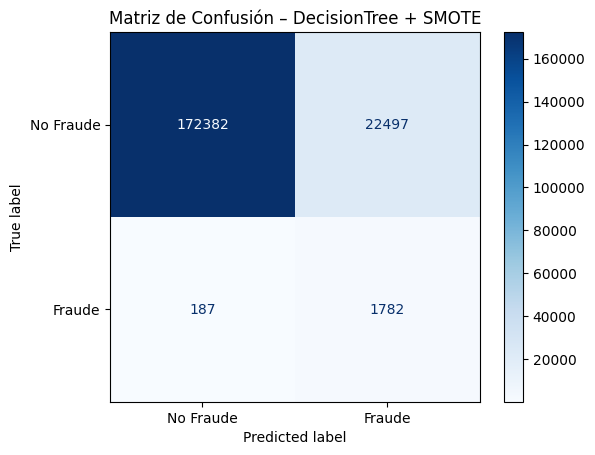

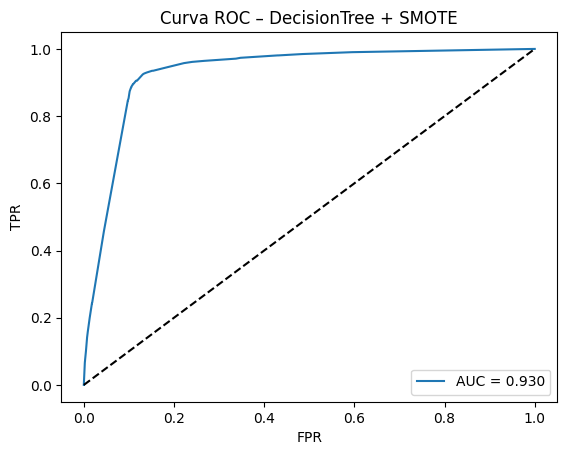

In [7]:
# Split antes de SMOTE (SMOTE solo en train dentro del pipeline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenar con el mejor pipeline (o con pipe si no hiciste GridSearch)
final_model = best_pipe if 'best_pipe' in globals() else pipe
final_model.fit(X_train, y_train)

# Predicción y reporte
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – DecisionTree + SMOTE")
plt.show()

# AUC ROC (usando predict_proba si disponible)
if hasattr(final_model.named_steps["model"], "predict_proba"):
    y_prob = final_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC – DecisionTree + SMOTE")
    plt.legend()
    plt.show()

In [8]:
#Esto calcula un test de la curva ROC para ver si tiene algun sobreajuste, no lo comprendo mucho pero segun el resultado no tiene mucho sobreajuste 
y_prob_train = final_model.predict_proba(X_train)[:, 1]
y_prob_test = final_model.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

print(f"AUC entrenamiento: {auc_train:.3f}")
print(f"AUC test: {auc_test:.3f}")

AUC entrenamiento: 0.935
AUC test: 0.930


# Conclusion del modelo

# El modelo DecisionTreeClassifier con class_weight="balanced" y SMOTE logró un recall del 90% en la detección de fraudes, mejorando drásticamente la  capacidad de identificación respecto al modelo KNN.
# Aunque la precisión disminuyó (7%), el objetivo principal —detectar fraudes reales— se cumple satisfactoriamente.
# El modelo muestra una clara sensibilidad hacia la clase minoritaria, lo que lo hace útil como etapa inicial de detección, aunque puede optimizarse con modelos de ensamble (Random Forest, XGBoost) para reducir falsos positivos.

# Clase	Precision	Recall	F1-score	Soporte	Interpretación
# 0 (No fraude)	0.999	0.885	0.938	194 879	El modelo clasifica correctamente la mayoría de las transacciones legítimas (88.5%), con casi ningún falso fraude (precisión casi perfecta).
# 1 (Fraude)	0.073	0.905	0.136	1 969	Detecta el 90.5% de los fraudes reales , pero solo el 7.3% de sus alertas son fraudes verdaderos (muchos falsos positivos).

# Métrica global	Valor	Qué significa
# Accuracy = 0.885	Muy alta, pero no relevante aquí. Se ve afectada por el gran número de transacciones legítimas.

# CONCLUSION FINAL
# EL MODELO DETECTA MUCHOS DE LOS FRAUDES PERO TIENE TAMBIÉN MUCHOS FALSOS POSITIVOS LO QUE PUEDE SER BUENO PARA LA DETECCION PERO PUEDE PROVOCAR PROBLEMAS CAUSANDO LA NECESIDAD DE UNA REVISION MANUAL Y PODRÍA PROVOCAR BLOQUEOS AUTOMATICOS
# Precisión del 7.3 % significa que de cada 100 alertas de fraude, 93 son falsos positivos.

# ESTE MODELO PODRÍA OPTIMIZARSE CON OTRO MODELO DE ENSABLE PARE REDUCIR FALSOS POSITIVOS COMO SE MENCIONA ARRIBA :D